# Cognitive Test Score Prediction
## Author: Ziqi Chen

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn import metrics
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Step1: Prepare Data

Observing the raw data in ".txt" format, we see that it is a file with a header row and 2170 datapoints. The variable names and corresponding values are seperated by "|" in each row and all the information are stacked vertically in one column. Loading data in this step will give us a dataframe having columns of index, variable names, and corresponding values. (For data extraction, we have an assumption that the data are stored in vertical order correspondingly, i.e. datapoints are from the same observation if they have the same corresponding order vertically in variable cateogries.)

__-Variables will be renamed according to descriptions in Data dictionary:__ 
* i - "mom_IQ"
* a - "mom_age_at_kid_birth"
* h - "high_school_completion"
* w: "work_status"
* score - "child_IQ"

__-By the nature of data meaning, the types of data for each variable will be:__
* "mom_IQ" - __float__ (IQ scores are continuous)
* "mom_age_at_kid_birth" - __integer__ (Ages are collected as integers)
* "high_school_completion" - __integer__ (categorical variable taking values 0 or 1)
* "work_status" - __integer__ (categorical variable taking values 1,2,3 or 4)
* "child_IQ" - __float__ (IQ scores are continuous)

Since it would be more readable and convenient to convert types after transforming variables into seperated columns, this manipulation will be actually processed in "Step2: Transform Data". 

In [2]:
# Read in data, specify encoding parameter to avoid invalid byte impeding loading data
raw = pd.read_table("data.txt", delimiter = "|", encoding = 'unicode_escape')

# Rename variables
raw['variable'] = raw['variable'].map({'i': 'mom_IQ', 'a': 'mom_age_at_kid_birth', 'h': 'high_school_completion', 
                                       'w': 'work_status', 'score': 'child_IQ'})

raw.head()

,,variable,value
0,0,child_IQ,65
1,1,child_IQ,98
2,2,child_IQ,85
3,3,child_IQ,83
4,4,child_IQ,115


## Step2: Transform Data

The objective is to transform raw data into a dataframe with each column stands for a single variable's observations.

Using functions in pandas library, follow the procedure:
- firstly group the "variable" column in raw data by variable names to make sure values for each category are collected into one row
- then convert each series of values in "value" column to columns of individual values
- lastly transpose each row of individual variable to each column of individual variable

In [3]:
# Group by variable names
grouped = pd.DataFrame(raw.groupby("variable")["value"], columns=["variable", "value"])

# Convert each Series of values in each variable to a List in each
grouped.value = grouped.value.apply(lambda x: x.values)

# Form a dataframe that converted each list of values to columns of values, then transpose the dataframe
values = pd.DataFrame(grouped.value.to_list())
data = values.set_index(grouped.variable).T

data = data.rename_axis(None, axis = 1)
data

,child_IQ,high_school_completion,mom_IQ,mom_age_at_kid_birth,work_status
0,65,1,'121.117528602603',27,4
1,98,1,'89.3618817100663',25,4
2,85,1,'115.443164881725',27,4
3,83,1,'99.4496394360723',25,3
4,115,1,'92.7457099982118',27,4
...,...,...,...,...,...
429,94,0,'84.8774118257353',21,4
430,76,1,'92.9903917236843',23,4
431,50,0,'94.8597081943671',24,2
432,88,1,'96.8566241253673',21,2


In [4]:
# Manipulate data types
data["mom_IQ"] = data["mom_IQ"].apply(lambda x: x.replace("'",""))
data = data.astype({"mom_age_at_kid_birth": "int", "high_school_completion": "int", "mom_IQ": "float", 
                    "child_IQ": "float", "work_status": "int"})

data.head()

,child_IQ,high_school_completion,mom_IQ,mom_age_at_kid_birth,work_status
0,65.0,1,121.117529,27,4
1,98.0,1,89.361882,25,4
2,85.0,1,115.443165,27,4
3,83.0,1,99.449639,25,3
4,115.0,1,92.745710,27,4


In [6]:
# remove outlier where child_IQ == 20
data = data.drop(285) 

To prepare for running models in later steps, I apply one-hot encoding on categorical variables to convert them into dummies. Dropping one of encoding columns is essentially important to linear models. (Even though "statsmodels.formula.api" could automatically deal with categorical variable by spcifying with "C( )" in the formula setup, I still encode it manually here for general applications of other models.)

In [21]:
# convert categorical values into dummies using one-hot encoding
df = pd.get_dummies(data=data, columns=["high_school_completion","work_status"], drop_first=True)

df.head()

,child_IQ,mom_IQ,mom_age_at_kid_birth,high_school_completion_1,work_status_2,work_status_3,work_status_4
0,65.0,121.117529,27,1,0,0,1
1,98.0,89.361882,25,1,0,0,1
2,85.0,115.443165,27,1,0,0,1
3,83.0,99.449639,25,1,0,1,0
4,115.0,92.745710,27,1,0,0,1


I identify the dependent variable (child's IQ) as x and independent variables (mother's IQ, mother's age at child's birth, mother's completion of high school, and mother's work status in first three years of child's life) as y.

For fitting and evaluating predictions, I split the dataset including dependent variable and independent variables into 80% for training and 20% for testing, and set a random_state with a fixed number so that the result will not be changed by every time run the cell.

In [22]:
# Identify dependent & independent variables, and train & test datasets
x = df.loc[:, df.columns != "child_IQ"]
y = df.loc[:, df.columns == "child_IQ"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [23]:
X_train.describe()

,mom_IQ,mom_age_at_kid_birth,high_school_completion_1,work_status_2,work_status_3,work_status_4
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,99.790736,22.725434,0.774566,0.234104,0.138728,0.450867
std,14.940221,2.685936,0.418473,0.424051,0.346163,0.498301
min,71.037405,17.000000,0.000000,0.000000,0.000000,0.000000
25%,88.597829,21.000000,1.000000,0.000000,0.000000,0.000000
50%,97.911590,23.000000,1.000000,0.000000,0.000000,0.000000
75%,110.272742,25.000000,1.000000,0.000000,0.000000,1.000000
max,136.577170,29.000000,1.000000,1.000000,1.000000,1.000000


In [24]:
X_test.describe()

,mom_IQ,mom_age_at_kid_birth,high_school_completion_1,work_status_2,work_status_3,work_status_4
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000
mean,101.021521,23.022989,0.839080,0.160920,0.091954,0.563218
std,15.265247,2.778560,0.369587,0.369587,0.290636,0.498863
min,74.230245,17.000000,0.000000,0.000000,0.000000,0.000000
25%,88.847099,21.000000,1.000000,0.000000,0.000000,0.000000
50%,99.172560,23.000000,1.000000,0.000000,0.000000,1.000000
75%,110.844582,25.000000,1.000000,0.000000,0.000000,1.000000
max,138.893106,28.000000,1.000000,1.000000,1.000000,1.000000


## Step3: Exploratory Data Analysis

General findings of the dataset: 
* Total of 434 observations in our sample and each observation consists of values for 5 variables
* The mother's average age of giving birth is around 23-year-old
* 78.57% of mothers in our sample finished high school
* Almost 50% of mothers worked full-time in first year of child's life and 39.86% of mothers did not work in the first year of child's life
* The average IQ score of mothers is 100 and of children is around 87 in our sample

Diving into the distribution of our dataset, there is only one outlier observed in "Child's IQ" among all three of numerical variables, it is assumed to be not significantly impact the data.

In [27]:
# number of missing values in each column
pd.DataFrame(data.isnull().sum(), columns=['number of missing values'])

,number of missing values
child_IQ,0
high_school_completion,0
mom_IQ,0
mom_age_at_kid_birth,0
work_status,0


In [28]:
data.dtypes

child_IQ                  float64
high_school_completion      int64
mom_IQ                    float64
mom_age_at_kid_birth        int64
work_status                 int64
dtype: object

In [29]:
# general statistics of the dataset
data.describe()

,child_IQ,high_school_completion,mom_IQ,mom_age_at_kid_birth,work_status
count,433.000000,433.000000,433.000000,433.000000,433.000000
mean,86.951501,0.787529,100.038030,22.785219,2.898383
std,20.179403,0.409530,14.996390,2.704174,1.181972
min,38.000000,0.000000,71.037405,17.000000,1.000000
25%,74.000000,1.000000,88.660321,21.000000,2.000000
50%,90.000000,1.000000,97.915254,23.000000,3.000000
75%,102.000000,1.000000,110.331388,25.000000,4.000000
max,144.000000,1.000000,138.893106,29.000000,4.000000


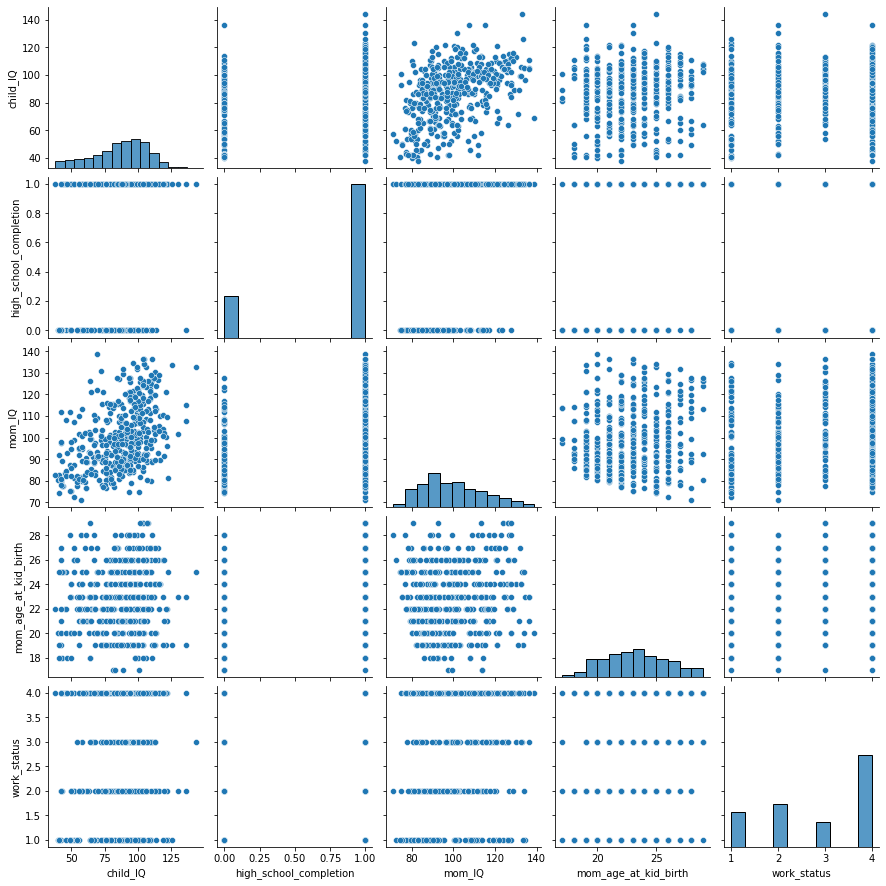

In [30]:
sns.pairplot(data)
plt.show()

__The distribution of dependent variable (child's IQ) is slight left skewed. Child's IQ in our sample has an average of 86.8 which is slightly below the children average score of 100 proposed by "TEST-GUIDE.com". (https://www.test-guide.com/iq-test-for-kids.html#:~:text=What%20is%20a%20normal%20IQ,basic%20understanding%20of%20cognitive%20concepts.)__

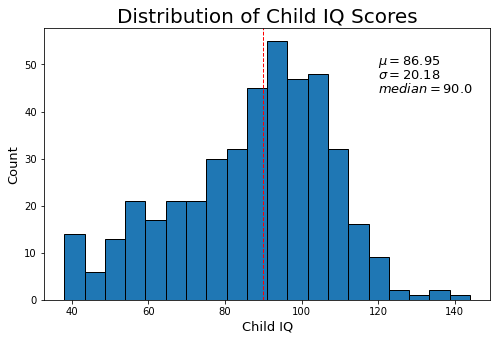

In [31]:
plt.figure(figsize=(8,5))
plt.hist(data["child_IQ"], bins=20, edgecolor='k')
plt.xlabel('Child IQ', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.axvline(data["child_IQ"].median(), color='r', linestyle='dashed', linewidth=1)
plt.text(120, 50, f'$\\mu = {round(data.child_IQ.mean(),2)}$', fontsize=13)
plt.text(120, 47, f'$\\sigma = {round(data.child_IQ.std(),2)}$', fontsize=13)
plt.text(120, 44, f'$median = {round(data.child_IQ.median(),2)}$', fontsize=13)
plt.title("Distribution of Child IQ Scores", fontsize=20)
plt.show()

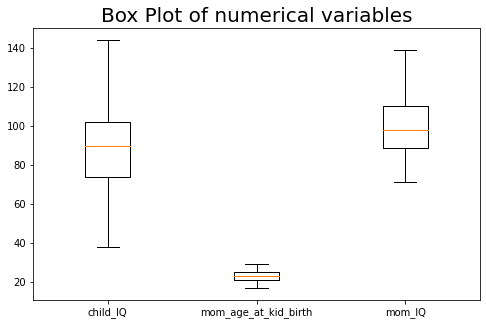

In [82]:
plt.figure(figsize=(8,5))
plt.boxplot(data[["child_IQ", "mom_age_at_kid_birth", "mom_IQ"]])
plt.title("Box Plot of numerical variables", fontsize=20)
plt.xticks([1, 2, 3], ["child_IQ", "mom_age_at_kid_birth", "mom_IQ"])
plt.show()

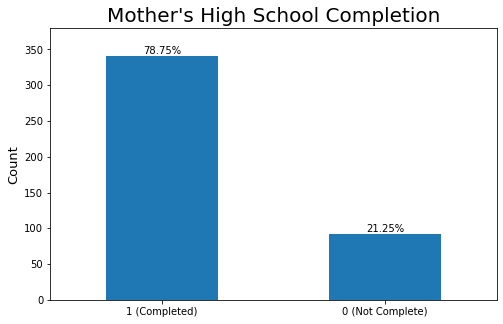

In [33]:
perc = [100*len(data[data["high_school_completion"] == 1])/len(data), 
        100*len(data[data["high_school_completion"] == 0])/len(data)]
f_perc = ['%.2f%%' % p for p in perc]

plt.figure(figsize=(8,5))
fig = data['high_school_completion'].value_counts().plot(kind='bar') # plot bar chart
fig.bar_label(fig.containers[0], labels=f_perc, label_type='edge', fontsize=10) # add percentage labels
fig.set_xticklabels(['1 (Completed)', '0 (Not Complete)'])
plt.ylabel('Count', fontsize=13)
plt.ylim([0,380]) # adjust y axis range
plt.title("Mother's High School Completion", fontsize=20)
plt.xticks(rotation=0)
plt.show()

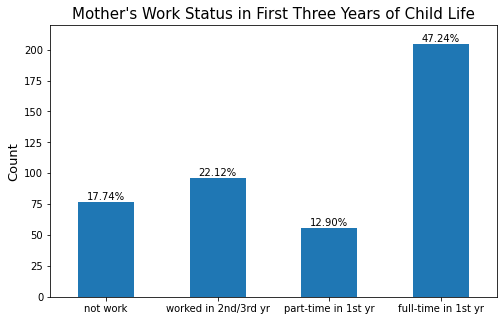

In [66]:
perc2 = [100*len(data[data["work_status"] == 1])/len(data), 
         100*len(data[data["work_status"] == 2])/len(data),
         100*len(data[data["work_status"] == 3])/len(data),
         100*len(data[data["work_status"] == 4])/len(data)]
f_perc2 = ['%.2f%%' % p for p in perc2]

plt.figure(figsize=(8,5))
fig = data['work_status'].value_counts().sort_index().plot(kind='bar')
fig.bar_label(fig.containers[0], labels=f_perc2, label_type='edge', fontsize=10)
plt.title("Mother's Work Status in First Three Years of Child Life", fontsize=15)
fig.set_xticklabels(['not work', 'worked in 2nd/3rd yr', "part-time in 1st yr", 'full-time in 1st yr'])
plt.ylabel('Count', fontsize=13)
plt.ylim([0,220])
plt.xticks(rotation=0)
plt.show()

__Most variables in our dataset do not have significant correlations. In the correlation heatmap, Child's IQ and Mother's IQ shows a relatively high positive correlation of 0.45 which indicates that these two variables are likely to move in the same direction. This is evidenced by scatter plot of Child's IQ versus Mother's IQ in the previous pairplot.__

Text(0.5, 1.0, 'Correlation Heatmap')

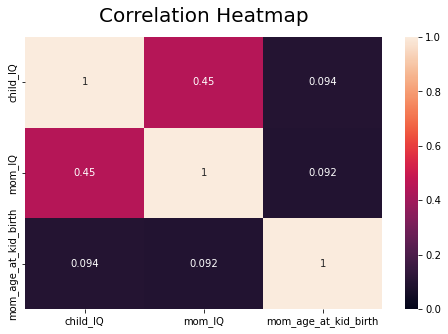

In [34]:
num_vars = data[["child_IQ", "mom_IQ", "mom_age_at_kid_birth"]]
plt.figure(figsize=(8,5))
heatmap = sns.heatmap(num_vars.corr(), vmin=0, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=15)

## Step4: Linear Regression

### 1) Using a single predictor

#### - Model Explanation
- Selecting which single predictor?
  
  In the case of including only one predictor, selecting the predictor which has the highest correlation with the   dependent variable is most reasonable. Because out of all the four possible linear regression models with a single predictor, this model will have the highest beta coefficient and the highest R-squared. Therefore, I'll only include "Mother's IQ" in this single predictor model as it has the highest correlation with "Child's IQ".
<br></br>
- Model Assumptions

    - Linear Relationship: There exist linear relationship between Mother's IQ and Child's IQ
    - Independence (No Autocorrelation): The residuals are independent in the model
    - Normality: The residuals are normally distributed in the model
    - Equal Variance (Homoscedasticity): The residuals have the same variance
<br></br>  
- Model Interpretation

  The model has an R-squared of 0.212 indicating that 21.2% of the variance for Child's IQ are explained by Mother's IQ. The P-value of F-statistic is smaller than 0.05 means that this regression model is significant. 
  
  P-values for "mom_IQ" is smaller than 0.05 which means the coefficient is statistically significant. The traning set regression result implies an equation as __*Child's IQ = 24.0480 + 0.6308 * Mother's IQ*__. One unit increase in Mother's IQ is estimated to increase 0.6308 in Child's IQ on average.

In [35]:
# Create regression object with training dataset and fit the regression model
trainX1 = sm.add_constant(X_train[["mom_IQ"]])
reg = sm.OLS(y_train, trainX1).fit()

# Present regression training result

reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     81.95
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           1.06e-17
Time:                        16:57:23   Log-Likelihood:                -1497.7
No. Observations:                 346   AIC:                             2999.
Df Residuals:                     344   BIC:                             3007.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.2401      6.692      4.070      0.000      14.077      40.403
mom_IQ         0.6004      0.066      9.053      0.000       0.470       0.731
==============================================================================
Omnibus:                        5.981   Durbin-Watson:                   1.821
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                6.085
Skew:                          -0.305   Prob(JB):                       0.0477
Kurtosis:                       2.776   Cond. No.                         682.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
# Predict child IQ in test dataset
testX1 = sm.add_constant(X_test[["mom_IQ"]])
predictions1 = reg.predict(testX1)

# predictions

#### - Visualize the Model Performance
Two visualizations below show the performance of the regression model on training set and testing set. In these two scatter plots, blue points are actual observations, and red regression lines are the predicted results by inputting training and testing set into the model.

Prediction on training set works relatively better than testing set because the actual observations are less scattered from regression line in traning test predictions. This may due to the nature that training set has more datapoints than testing set and is more efficient in catching variances.

This simple regression model has an MSE equal to 338.65.

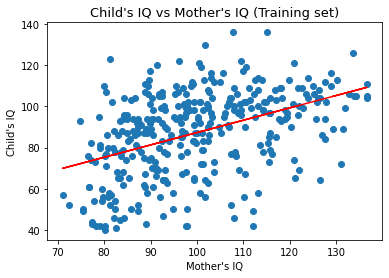

In [37]:
# training performance
plt.scatter(X_train["mom_IQ"], y_train)
plt.plot(X_train["mom_IQ"], reg.predict(trainX1), color = "red")
plt.title("Child's IQ vs Mother's IQ (Training set)", fontsize=13)
plt.xlabel("Mother's IQ")
plt.ylabel("Child's IQ")
plt.show()

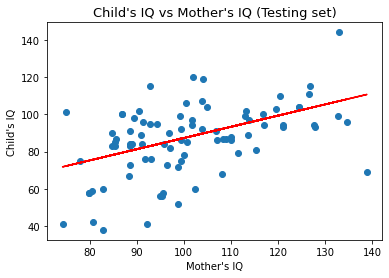

In [38]:
# testing performance
plt.scatter(X_test["mom_IQ"], y_test)
plt.plot(X_test["mom_IQ"], predictions1, color = "red")
plt.title("Child's IQ vs Mother's IQ (Testing set)", fontsize=13)
plt.xlabel("Mother's IQ")
plt.ylabel("Child's IQ")
plt.show()

In [39]:
# MSE of the predictions
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, predictions1)))

Mean Squared Error: 280.6483551009078


#### - Model Diagnostics

- __Linearity__: The scatter plot of Child's IQ versus Mother's IQ have an upwarding slope, indicating there is an positive linear association between these two variables.

- __Independence__: The result of Durbin_watson is between 1.5 and 2.5 meaning that residuals are independent.

- __Normality__: Residuals are mostly spread along diagonal line in Q-Q plot, which implies that the residuals follow a normal distribution.

- __Homoscedasticity__: Roughly, the points have equal variance except that variance is slightly different when fitted value grows above 100.

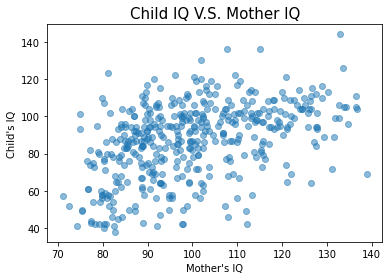

In [40]:
# Linearity
plt.scatter(data["mom_IQ"], data["child_IQ"], alpha=0.5)
plt.xlabel('Mother\'s IQ', fontsize=10)
plt.ylabel('Child\'s IQ', fontsize=10)
plt.title("Child IQ V.S. Mother IQ", fontsize=15)
plt.show()

In [42]:
# Independence
res1 = y_train.values.copy() - reg.predict(trainX1).values.copy().reshape((346,1))
def check_indep(residual):
    d = durbin_watson(residual)
    print("Durbin_watson: " + str(d[0]))
    if d[0] > 1.5 and d[0] < 2.5:
        print("No autocorrelation, residuals are independent")
    else:
        print("residuals are not independent")
check_indep(res1)

Durbin_watson: 1.8213869390582906
No autocorrelation, residuals are independent


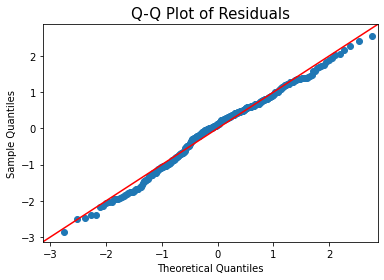

In [44]:
# Normality 
sm.qqplot(res1.reshape(346), line='45', fit = True)
plt.title("Q-Q Plot of Residuals", fontsize=15)
plt.show()

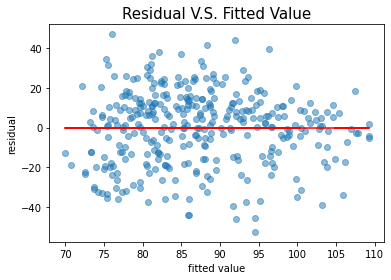

In [45]:
# Equal Variance
plt.scatter(reg.predict(trainX1), res1, alpha=0.5)
plt.plot(reg.predict(trainX1), [0] * len(reg.predict(trainX1)), color = "red")
plt.xlabel('fitted value', fontsize=10)
plt.ylabel('residual', fontsize=10)
plt.title("Residual V.S. Fitted Value", fontsize=15)
plt.show()

### 2) Using multiple predictors

#### - Model Explanation

- Include which variables?

  Including more variables is likely to help us improve the model performance. Due to a small number of variables available, I decided to include all the four possible predictors into a multiple linear regression model.
<br></br>  
- Model Assumptions

    - Linear Relationship: There exist linear relationship between Child's IQ and those 4 predictors
    - Independence (No Autocorrelation): The residuals are independent in the model
    - Normality: The residuals are normally distributed in the model
    - Equal Variance (Homoscedasticity): The residuals have the same variance
    - No Multicollinearity: The independent variables are not highly intercorrelating
<br></br>  
- Model Interpretation

  An increase in adjusted R-squared compared to the simple linear regression model indicates that adding additional variables help enhance the explanatory power of our model. R-squared implying this model explains 22.8% of the variance for Child's IQ. However, the F-statistic droped significantly from simple linear model, and this might because the newly included variables have tiny correlation with dependent variable and may add bias in this model.

  Only "mom_IQ" and "high_school_completion_1" has P-value less than significance level of 0.05, meaning that only these two independent variables' coefficients are statistically significant. In this model, one unit increase in mother's IQ will increase child's IQ by 0.5797 on average. If the mother completed high school, then the child's IQ is likely to be enhanced by 5.07 on average.

In [46]:
# Create regression object with training dataset and fit the regression model
trainX = sm.add_constant(X_train)
reg = sm.OLS(y_train, trainX).fit()

# Present regression training result
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.194
Method:                 Least Squares   F-statistic:                     14.88
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           4.11e-15
Time:                        16:58:12   Log-Likelihood:                -1494.3
No. Observations:                 346   AIC:                             3003.
Df Residuals:                     339   BIC:                             3029.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       22.0534     10.858      2.031      0.043       0.695      43.411
mom_IQ                       0.5586      0.069      8.075      0.000       0.422       0.695
mom_age_at_kid_birth         0.1720      0.378      0.455      0.650      -0.572       0.916
high_school_completion_1     4.1633      2.550      1.632      0.104      -0.853       9.180
work_status_2                3.5294      3.151      1.120      0.263      -2.668       9.727
work_status_3                5.5272      3.615      1.529      0.127      -1.583      12.638
work_status_4                1.4199      2.860      0.496      0.620      -4.206       7.046
==============================================================================
Omnibus:                        4.856   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.088   Jarque-Bera (JB):                4.897
Skew:                          -0.266   Prob(JB):                       0.0864
Kurtosis:                       2.762   Cond. No.                     1.14e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.14e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# Predict child IQ in test dataset
testX = sm.add_constant(X_test)
predictions = reg.predict(testX) 

#predictions

#### - Visualize the Model Performance

A reduction of about 10 in Mean Squared Error was observed in this model compared to simple linear regression model. In the scatter plot of predicted results versus actual results, predicted results have a narrower range than actual results and the model does not work well in catching variances for lower Child's IQ.

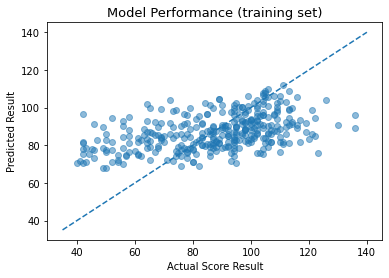

In [48]:
ax = plt.axes()
ax.scatter(y_train.values, reg.predict(trainX).values, alpha=0.5)
ax.plot([35,140], [35,140], ls="--")
ax.set_title("Model Performance (training set)", fontsize=13)
ax.set_xlabel('Actual Score Result')
ax.set_ylabel('Predicted Result')
plt.show()

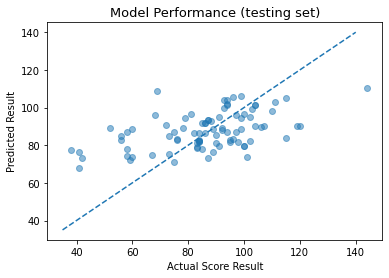

In [49]:
ax = plt.axes()
ax.scatter(y_test.values, predictions.values, alpha=0.5)
ax.plot([35,140], [35,140], ls="--")
ax.set_title("Model Performance (testing set)", fontsize=13)
ax.set_xlabel('Actual Score Result')
ax.set_ylabel('Predicted Result')
plt.show()

In [50]:
# MSE of the predictions
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, predictions)))

Mean Squared Error: 268.2732869286859


#### - Model Diagnostics

- __Linearity__: Besides scatter plot of Child's IQ V.S. Mother's IQ shown in previous part, I explored the relationship between Child's IQ and another numerical variable Mother's Age at Child's Birth. By the scatter plot, no obvious linear relationship detected between these two variables. 

- __Independence__: The result of Durbin_watson is between 1.5 and 2.5 meaning that residuals are independent.

- __Normality__: Residuals are mostly spread along diagonal line in Q-Q plot, which implies that the residuals follow a normal distribution.

- __Homoscedasticity__: Roughly, the points have equal variance except that variance is slightly different when fitted value grows above 100. Moreover, residuals are slightly more observed with positive values.

- __Multicollinearity__: According to the VIF table, "mom_IQ" and "mom_age_at_kid_birth" have high VIFs which indicates the existence of multicollinearity. This might be the reason lead to reduction of precision in estimating coefficients. We choose to remove "mom_age_at_kid_birth" because "mom_IQ" has higher correlation with dependent variable which means this variable has larger main effect on outcomes.

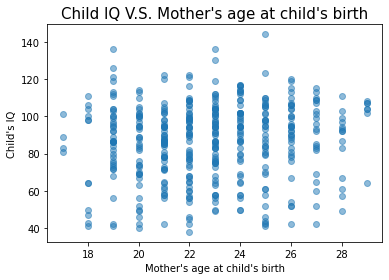

In [51]:
# Linearity
plt.scatter(data["mom_age_at_kid_birth"], data["child_IQ"], alpha=0.5)
plt.xlabel('Mother\'s age at child\'s birth', fontsize=10)
plt.ylabel('Child\'s IQ', fontsize=10)
plt.title("Child IQ V.S. Mother\'s age at child\'s birth", fontsize=15)
plt.show()

In [53]:
# Independence
res2 = y_train.values.copy() - reg.predict(trainX).values.copy().reshape((346,1))
check_indep(res2)

Durbin_watson: 1.87259356315142
No autocorrelation, residuals are independent


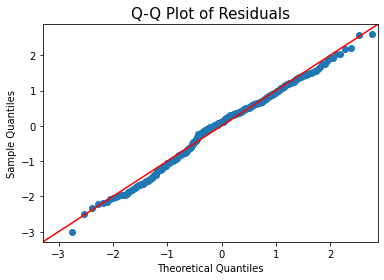

In [54]:
# Normality 
sm.qqplot(res2.reshape(346), line='45', fit = True)
plt.title("Q-Q Plot of Residuals", fontsize=15)
plt.show()

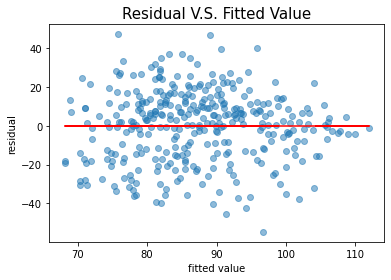

In [55]:
# Equal Variance
plt.scatter(reg.predict(trainX), res2, alpha=0.5)
plt.plot(reg.predict(trainX), [0] * len(reg.predict(trainX)), color = "red")
plt.xlabel('fitted value', fontsize=10)
plt.ylabel('residual', fontsize=10)
plt.title("Residual V.S. Fitted Value", fontsize=15)
plt.show()

In [56]:
# Multicollinearity
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Variable"] = X_train.columns
# calculating VIF for each variable
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]
  
print(vif_data)

                   Variable        VIF
0                    mom_IQ  32.130419
1      mom_age_at_kid_birth  31.168886
2  high_school_completion_1   5.047008
3             work_status_2   2.283168
4             work_status_3   1.861586
5             work_status_4   3.729301


### 3) Using multiple predictors with an interaction term

#### - Model Explanation

- Include which variables in the interaction term?

  I selected "Mother's IQ * the High School Completion" to be the interaction term. Firstly, these two variables have higher correlation with Child's IQ, thus they have larger main effect on the Child's IQ. Secondly, the crrelation table shows these two predictors correlated to each other as well, which can also be inferred from a common sense that mothers have higher IQ is more likely to have completed high school. Thirdly, from the scatter plot of the predictors and the dependent variable, we can observe that these two predictors seem not have parallel effect on the dependent variable. This scatter plot suggests a possible interaction effect on Mother's IQ and Child's IQ. 
<br></br>  
- Model Assumptions

    - Linear Relationship: There exist linear relationship between Child's IQ and these 5 predictors
    - Independence(No Autocorrelation): The residuals are independent in the model
    - Normality: The residuals are normally distributed in the model
    - Equal Variance (Homoscedasticity): The residuals have the same variance
    - No Multicollinearity: The independent variables are not highly intercorrelating
<br></br>  
- Model Interpretation

    In the model summary, both R-squared and adjusted R-squared enhanced from previous model. This suggests that more variations are explained and the newly included interaction term improves the explanatory power. The F-statistics can also affirm the significance of this model. 
    
    "mom_IQ", "high_school_completion_1", and the interaction term of these two variables has P-value less than significance level of 0.05, which implies the statistical significance. On average, one unit increase in Mother's IQ is estimated to increase Child's IQ by 0.9373, and 46.3508 if the mother completed high school. The coefficient of the interaction term (-0.4380) is the difference in the effectiveness of mother's IQ on child's IQ between those mothers who completed high school and those who do not.

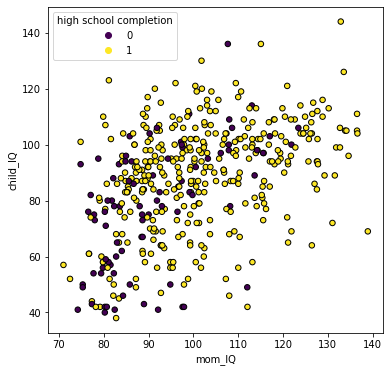

In [57]:
v1 = data["mom_IQ"]
v2 = data["child_IQ"]
v3 = data["high_school_completion"]

fig = plt.figure(figsize=(6, 6))
scatter = plt.scatter(v1, v2,
           linewidths=1,
           edgecolor='k',
           s = 30,
           c=v3.astype('category').cat.codes)
plt.xlabel('mom_IQ', fontsize=10)
plt.ylabel('child_IQ', fontsize=10)
plt.legend(handles=scatter.legend_elements()[0], labels=[0,1], title="high school completion")
plt.show()

#### - Visualize the Model Performance

There is also a reduction of 10 in Mean Squared Error from the MSE in multiple linear regression model. The scatter plots show a similar model performance compared to the previous one.

#### - Model Diagnostics
    
 - __Linearity__: Besides scatter plots from previous parts, I explored the relationship between Child's IQ and the interaction term as well. Observing the scatter plot, there is an linear relationship between mother's IQ who have finished high school and Child's IQ.

 - __Independence__: The result of Durbin_watson is between 1.5 and 2.5 meaning that residuals are independent.

 - __Normality__: Residuals are mostly spread along diagonal line in Q-Q plot, which implies that the residuals follow a normal distribution.

 - __Homoscedasticity__: Roughly, the points have equal variance except that variance is slightly different when fitted value grows above 100. Moreover, more residuals are clustered in range of 0 and 20 when fitted value is between 80 and 90. This indicates that there might exist heteroscedasticity to some extent.
 
 - __Multicollinearity__: "mom_IQ", "high_school_completion_1" and the interaction term have high VIF in this model. But we can ignore the increase in these two VIF because it was caused by product of variabels. 

In [70]:
# Add an interaction term to x datasets
inter2_X_train = X_train.copy()
inter2_X_test = X_test.copy()
inter2_X_train["mIQ*highschool"] = inter_X_train["mom_IQ"] * inter_X_train["high_school_completion_1"]
inter2_X_test["mIQ*highschool"] = inter_X_test["mom_IQ"] * inter_X_test["high_school_completion_1"]
inter2_X_train = inter2_X_train.drop('mom_age_at_kid_birth', axis=1)
inter2_X_test = inter2_X_test.drop('mom_age_at_kid_birth', axis=1)

In [71]:
# Create regression object with training dataset and fit the regression model
inter2_trainX = sm.add_constant(inter2_X_train)
reg = sm.OLS(y_train, inter2_trainX).fit()

# Present regression training result
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               child_IQ   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     15.86
Date:                Thu, 08 Dec 2022   Prob (F-statistic):           4.50e-16
Time:                        16:59:39   Log-Likelihood:                -1491.9
No. Observations:                 346   AIC:                             2998.
Df Residuals:                     339   BIC:                             3025.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.5962     15.022     -0.239      0.811     -33.143      25.951
mom_IQ                       0.8809      0.162      5.445      0.000       0.563       1.199
high_school_completion_1    41.7754     17.143      2.437      0.015       8.055      75.496
work_status_2                2.3669      3.158      0.749      0.454      -3.846       8.579
work_status_3                5.0699      3.594      1.411      0.159      -1.999      12.138
work_status_4                0.7245      2.858      0.253      0.800      -4.897       6.346
mIQ*highschool              -0.3943      0.179     -2.205      0.028      -0.746      -0.042
==============================================================================
Omnibus:                        5.492   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.574
Skew:                          -0.290   Prob(JB):                       0.0616
Kurtosis:                       2.775   Cond. No.                     2.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [72]:
# Predict child IQ in test dataset
inter2_testX = sm.add_constant(inter2_X_test)
inter2_predictions = reg.predict(inter2_testX) 

#predictions

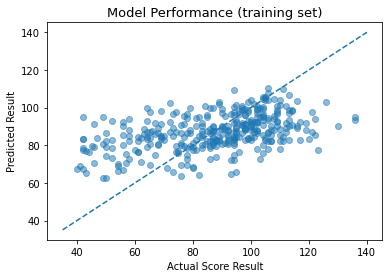

In [73]:
ax = plt.axes()
ax.scatter(y_train.values, reg.predict(inter2_trainX).values, alpha=0.5)
ax.plot([35,140], [35,140], ls="--")
ax.set_title("Model Performance (training set)", fontsize=13)
ax.set_xlabel('Actual Score Result')
ax.set_ylabel('Predicted Result')
plt.show()

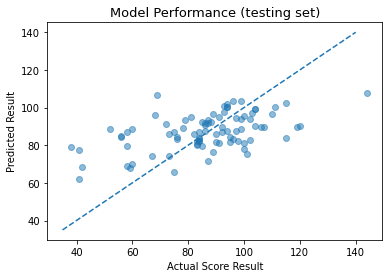

In [74]:
ax = plt.axes()
ax.scatter(y_test.values, inter2_predictions.values, alpha=0.5)
ax.plot([35,140], [35,140], ls="--")
ax.set_title("Model Performance (testing set)", fontsize=13)
ax.set_xlabel('Actual Score Result')
ax.set_ylabel('Predicted Result')
plt.show()

In [75]:
# MSE of the predictions
print("Mean Squared Error: " + str(metrics.mean_squared_error(y_test, inter2_predictions)))

Mean Squared Error: 261.16624456825076


In [77]:
# Independence
res3 = y_train.values.copy() - reg.predict(inter2_trainX).values.copy().reshape((346,1))
check_indep(res3)

Durbin_watson: 1.866523210226491
No autocorrelation, residuals are independent


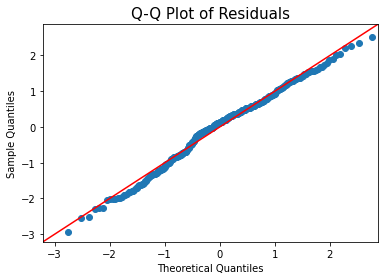

In [79]:
# Normality 
sm.qqplot(res3.reshape(346), line='45', fit = True)
plt.title("Q-Q Plot of Residuals", fontsize=15)
plt.show()

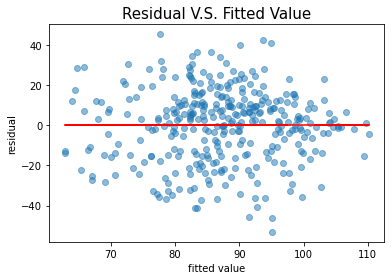

In [80]:
# Equal Variance
plt.scatter(reg.predict(inter2_trainX), res3, alpha=0.5)
plt.plot(reg.predict(inter2_trainX), [0] * len(reg.predict(inter2_trainX)), color = "red")
plt.xlabel('fitted value', fontsize=10)
plt.ylabel('residual', fontsize=10)
plt.title("Residual V.S. Fitted Value", fontsize=15)
plt.show()

In [81]:
# Multicollinearity
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["Variable"] = inter2_X_train.columns
# calculating VIF for each variable
vif_data["VIF"] = [variance_inflation_factor(inter2_X_train.values, i)
                          for i in range(len(inter2_X_train.columns))]
  
print(vif_data)

                   Variable        VIF
0                    mom_IQ   9.067693
1  high_school_completion_1  53.853460
2             work_status_2   2.429222
3             work_status_3   1.863659
4             work_status_4   3.833437
5            mIQ*highschool  56.980350


## Conclusion

Based on the given data, the linear regression model performed prediction for cognitive test scores of preschoolers with a high MSE and low R-squared. The model does not work well may due to the multicollinearity among predictors and lack of informative features. To improve the model performance, we could collect more features and select or combine some of the feature based on their correlations (techniques such as PCA, LASSO etc. can be introduced then). Moreover, we could improve the prediction performance by applying some non-linear models such as Random Forest.